In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
# 讀取數據
file_path = "F:\\All data\\Patient_Signal\\PPG.csv"
data = pd.read_csv(file_path, header=None)
data.columns = ['Name', 'i', 'Bad', 'hands', 'label', 'systolic peak', 'Diastolic peak', 'Cardiac cycle', 
                'Cycle Area', 'SSI', 'Peak to Valley', 'Systolic peak y', 'Delta_T', 
                '1st Derivative cycle', '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA', 
                'Ratio_BDCE_A', 'Ratio_CDB_A']

# 提取特徵和標籤
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤

# 進行曼惠特尼 U 檢定
significant_features = []
p_values = {}

for column in X.columns:
    group_0 = X[y == 0][column]
    group_1 = X[y == 1][column]
    stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
    p_values[column] = p_value
    if p_value < 0.05:
        significant_features.append(column)

# 輸出顯著性特徵及其 p-value
print("顯著性特徵及其 p-value：")
for feature, p_value in p_values.items():
    if feature in significant_features:
        print(f"{feature}: p-value = {p_value:.4f} *")
    else:
        print(f"{feature}: p-value = {p_value:.4f}")

# 使用顯著性特徵進行分類
X_significant = X[significant_features]

info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



顯著性特徵及其 p-value：
systolic peak: p-value = 0.0000 *
Diastolic peak: p-value = 0.0000 *
Cardiac cycle: p-value = 0.0005 *
Cycle Area: p-value = 0.3344
SSI: p-value = 0.0000 *
Peak to Valley: p-value = 0.1083
Systolic peak y: p-value = 0.5034
Delta_T: p-value = 0.0000 *
1st Derivative cycle: p-value = 0.0000 *
1st Derivative peak: p-value = 0.0001 *
Ratio_BA: p-value = 0.0137 *
Ratio_CA: p-value = 0.0166 *
Ratio_DA: p-value = 0.0006 *
Ratio_BDCE_A: p-value = 0.0000 *
Ratio_CDB_A: p-value = 0.4196


In [11]:
# 繪製混淆矩陣
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5), dpi=120)
    plt.imshow(conf_matrix, cmap='summer')
    plt.colorbar()

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), fontsize=12,
                     horizontalalignment='center', verticalalignment='center')


    
    plt.xticks(np.arange(0, 2), ['Predicted 0', 'Predicted 1'])
    plt.yticks(np.arange(0, 2), ['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

In [12]:
# 計算性能指標
def calculate_metrics(conf_matrix):
    tp = conf_matrix[0, 0]
    fn = conf_matrix[0, 1]
    fp = conf_matrix[1, 0]
    tn = conf_matrix[1, 1]
    accuracy = (tp + tn) / (tp + fn + fp + tn) if (tp + fn + fp + tn) != 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

    metrics = {
        "Accuracy": round(accuracy,3),
        "Sensitivity (Recall)": round(sensitivity,3),
        "Specificity": round(specificity,3),
        "Precision": round(precision,3),
        "F1-Score": round(f1_score,3)
    }
    return metrics

In [13]:
# 儲存結果到 CSV
def save_results_to_csv(filename, info, y_test, y_pred):
    new_data = pd.DataFrame({
        'Name': info['Name'].values,
        'Cycle': info['i'].values,
        'Hands': info['hands'].values,
        'Actual_Label': y_test.values,
        'Predicted_Label': y_pred
    })

    new_data = new_data.sort_values(by='Name')
    new_data['Is_Correct'] = new_data['Actual_Label'] == new_data['Predicted_Label']
    new_data.to_csv(f"F:\\All data\\Patient_Signal\\UTest\\{filename}.csv", index=False, encoding='utf-8-sig')
    print(f"Results saved to {filename}.csv")

    # 將最終的 Actual_Label 和 Predicted_Label 的總結結果保存
    final_summary = new_data.groupby('Name').agg(
    Actual_0_Count=('Actual_Label', lambda x: (x == 0).sum()),
    Actual_1_Count=('Actual_Label', lambda x: (x == 1).sum()),
    Predicted_0_Count=('Predicted_Label', lambda x: (x == 0).sum()),
    Predicted_1_Count=('Predicted_Label', lambda x: (x == 1).sum())
    ).reset_index()

    # 判斷總體的預測結果
    final_summary['Predicted_Label'] = final_summary.apply(lambda row: 0 if row['Predicted_0_Count'] > row['Predicted_1_Count'] else 1, axis=1)
    final_summary['Actual_Label'] = final_summary.apply(lambda row: 0 if row['Actual_0_Count'] > row['Actual_1_Count'] else 1, axis=1)

    # 保存總結至 CSV
    final_summary.to_csv(f"F:\\All data\\Patient_Signal\\UTest\\{filename}_Final.csv", index=False, encoding='utf-8-sig')
    print(f"Results saved to {filename}_Final.csv")

    
    conf_matrix = confusion_matrix(final_summary['Actual_Label'], final_summary['Predicted_Label'])
    plot_confusion_matrix(conf_matrix, title='Final Confusion Matrix')
    metrics = calculate_metrics(conf_matrix)
    print("Final Metrics:", metrics)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
最佳參數: {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear'}
特徵重要性排序：
                  Feature  Importance
13          Ratio_BDCE_A    2.337676
10              Ratio_BA    2.318532
12              Ratio_DA    2.230880
14           Ratio_CDB_A    2.217666
6        Systolic peak y    0.786989
9    1st Derivative peak    0.570257
1         Diastolic peak    0.424346
3             Cycle Area    0.356213
5         Peak to Valley    0.268677
7                Delta_T    0.220571
0          systolic peak    0.219153
8   1st Derivative cycle    0.201783
4                    SSI    0.181332
11              Ratio_CA    0.115431
2          Cardiac cycle    0.093440


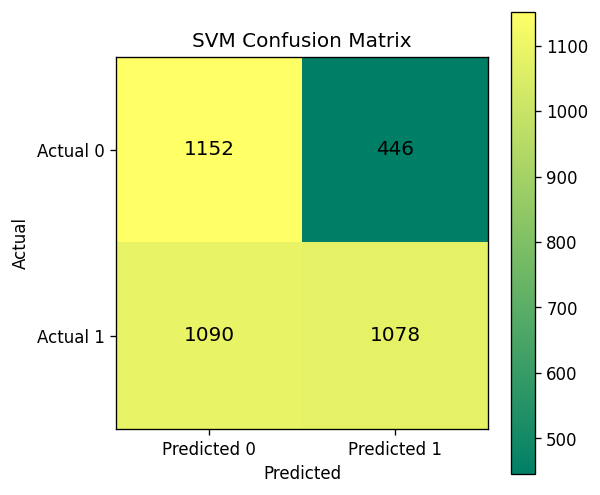

SVM Metrics: {'Accuracy': 0.592, 'Sensitivity (Recall)': 0.721, 'Specificity': 0.497, 'Precision': 0.514, 'F1-Score': 0.6}
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv


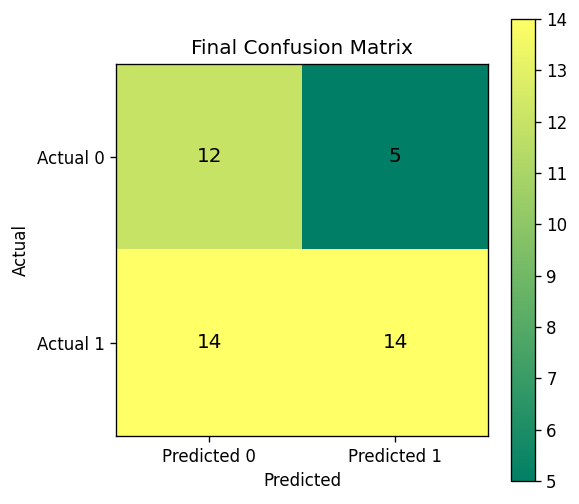

Final Metrics: {'Accuracy': 0.578, 'Sensitivity (Recall)': 0.706, 'Specificity': 0.5, 'Precision': 0.462, 'F1-Score': 0.558}


In [14]:
# 定義 SVM 模型
def train_svm(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear'],
        'class_weight': ['balanced']
    }

    svm_grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    svm_grid_search.fit(X_train, y_train)

    best_model = svm_grid_search.best_estimator_
    best_params = svm_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    feature_importance = np.abs(best_model.coef_[0])
    feature_importance_df = pd.DataFrame({
        'Feature': X_columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

        # 預測測試集

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred, feature_importance_df


# SVM
svm_model, svm_metrics, svm_conf_matrix, svm_y_pred, feature_importance_df = train_svm(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(svm_conf_matrix, title='SVM Confusion Matrix')
print("SVM Metrics:", svm_metrics)
save_results_to_csv('SVM_Results', info_test, y_test, svm_y_pred)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳參數: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
特徵重要性排序：
                  Feature  Importance
8   1st Derivative cycle    0.059474
1         Diastolic peak    0.053489
4                    SSI    0.044426
9    1st Derivative peak    0.043047
13          Ratio_BDCE_A    0.038705
12              Ratio_DA    0.037490
3             Cycle Area    0.032721
5         Peak to Valley    0.031757
11              Ratio_CA    0.031022
14           Ratio_CDB_A    0.027813
2          Cardiac cycle    0.024890
6        Systolic peak y    0.016415
10              Ratio_BA    0.013720
7                Delta_T    0.011107
0          systolic peak    0.010945


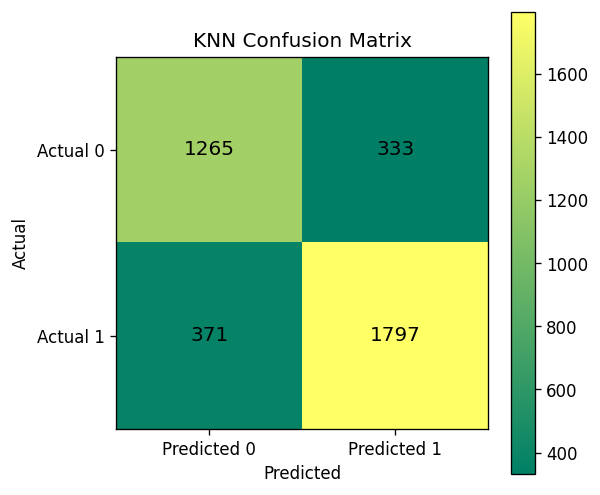

KNN Metrics: {'Accuracy': 0.813, 'Sensitivity (Recall)': 0.792, 'Specificity': 0.829, 'Precision': 0.773, 'F1-Score': 0.782}
Results saved to KNN_Results.csv
Results saved to KNN_Results_Final.csv


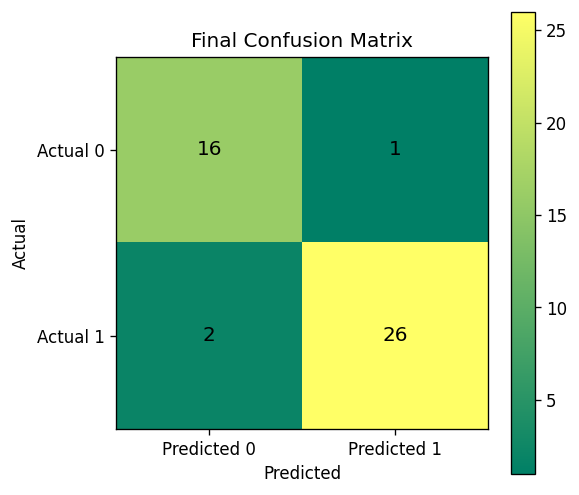

Final Metrics: {'Accuracy': 0.933, 'Sensitivity (Recall)': 0.941, 'Specificity': 0.929, 'Precision': 0.889, 'F1-Score': 0.914}


In [15]:
# 定義 KNN 模型
def train_knn(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    knn_grid_search.fit(X_train, y_train)

    best_model = knn_grid_search.best_estimator_
    best_params = knn_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    # 特徵重要性 - 基於相關性分析（例如皮爾森相關係數）
    feature_importance = np.abs(np.corrcoef(X_train.T, y_train.values, rowvar=True)[:-1, -1])
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

        # 預測測試集

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred

# KNN
knn_model, knn_metrics, knn_conf_matrix, knn_y_pred = train_knn(X_train, y_train, X_test, y_test)
plot_confusion_matrix(knn_conf_matrix, title='KNN Confusion Matrix')
print("KNN Metrics:", knn_metrics)
save_results_to_csv('KNN_Results', info_test, y_test, knn_y_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 100}
特徵重要性排序：
                  Feature  Importance
1         Diastolic peak    0.098386
9    1st Derivative peak    0.090774
3             Cycle Area    0.085785
10              Ratio_BA    0.085225
7                Delta_T    0.072831
14           Ratio_CDB_A    0.072824
0          systolic peak    0.064059
5         Peak to Valley    0.061678
13          Ratio_BDCE_A    0.060632
12              Ratio_DA    0.059737
11              Ratio_CA    0.059271
6        Systolic peak y    0.053817
4                    SSI    0.047301
2          Cardiac cycle    0.046671
8   1st Derivative cycle    0.041007


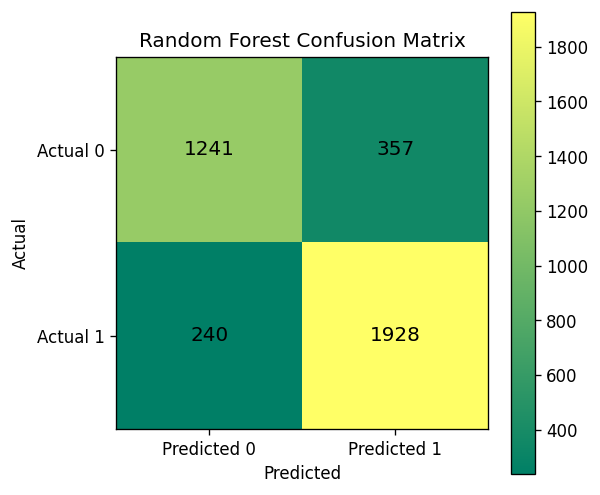

Random Forest Metrics: {'Accuracy': 0.841, 'Sensitivity (Recall)': 0.777, 'Specificity': 0.889, 'Precision': 0.838, 'F1-Score': 0.806}
Results saved to RF_Results.csv
Results saved to RF_Results_Final.csv


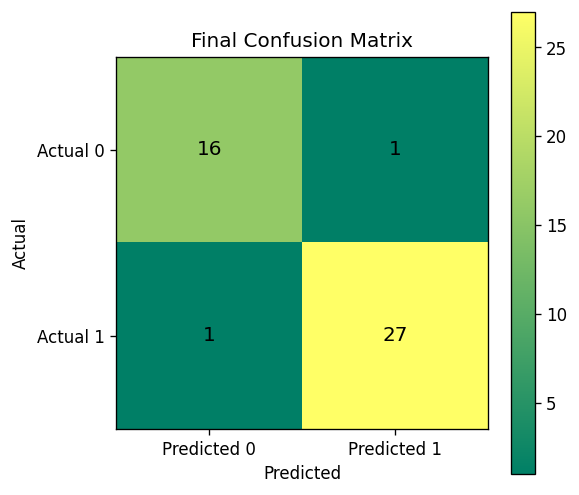

Final Metrics: {'Accuracy': 0.956, 'Sensitivity (Recall)': 0.941, 'Specificity': 0.964, 'Precision': 0.941, 'F1-Score': 0.941}


In [16]:
# 定義 Random Forest 模型
def train_rf(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    }

    rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    rf_grid_search.fit(X_train, y_train)

    best_model = rf_grid_search.best_estimator_
    best_params = rf_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

        # 特徵重要性 - Random Forest 原生支援
    feature_importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)
    
    return best_model, metrics, conf_matrix, y_pred

# Random Forest
rf_model, rf_metrics, rf_conf_matrix, rf_y_pred = train_rf(X_train, y_train, X_test, y_test)
plot_confusion_matrix(rf_conf_matrix, title='Random Forest Confusion Matrix')
print("Random Forest Metrics:", rf_metrics)
save_results_to_csv('RF_Results', info_test, y_test, rf_y_pred)
# 輸出結果